# Website Analytics – Exploratory Analysis

This notebook explores user behavior and conversion for a website using a synthetic analytics dataset. The goal is to understand how different traffic sources and user behaviors relate to session quality and conversion, and to document the main findings in a way that is clear for non-technical stakeholders.




## 0. Setup and data loading

In this section we import the necessary libraries and load the raw CSV file into a pandas DataFrame. We also create a cleaned working dataset (`df_clean`) where we remove sessions with zero page views, since they do not represent meaningful on-site activity.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw data
df = pd.read_csv("../data/website_wata.csv")

# Basic cleaning: remove sessions with 0 page views
df_clean = df[df["Page Views"] > 0].copy()

df_clean.shape


(1986, 7)

## 1. Data overview and cleaning

Here we perform a quick structural check of the cleaned dataset: shapes, data types, missing values and duplicated rows. This helps verify that the main variables are present in the expected format and that there are no obvious data quality issues before we start analyzing behavior and conversion.


In [16]:
# Strip whitespace from column names
df_clean.columns = [c.strip() for c in df_clean.columns]

cols = ['Page Views','Session Duration','Bounce Rate','Traffic Source',
        'Time on Page','Previous Visits','Conversion Rate']

print("shape:", df_clean.shape)
print("dtypes:\n", df_clean[cols].dtypes)

# Missing + duplicates
print("\nMissing by column:\n", df_clean[cols].isna().sum())
print("\nDuplicated rows:", df_clean.duplicated().sum())

# Conversion Rate stats
cr = df_clean['Conversion Rate']
print("\nConversion Rate stats:")
print(cr.describe())
print("nunique:", cr.nunique())
print("top values:\n", cr.value_counts().head(10))

# Bounce Rate stats
br = df_clean['Bounce Rate']
print("\nBounce Rate stats:")
print(br.describe())
print("nunique:", br.nunique())



shape: (1986, 7)
dtypes:
 Page Views            int64
Session Duration    float64
Bounce Rate         float64
Traffic Source       object
Time on Page        float64
Previous Visits       int64
Conversion Rate     float64
dtype: object

Missing by column:
 Page Views          0
Session Duration    0
Bounce Rate         0
Traffic Source      0
Time on Page        0
Previous Visits     0
Conversion Rate     0
dtype: int64

Duplicated rows: 0

Conversion Rate stats:
count    1986.000000
mean        0.982530
std         0.064240
min         0.343665
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Conversion Rate, dtype: float64
nunique: 222
top values:
 Conversion Rate
1.000000    1765
0.963080       1
0.868593       1
0.972277       1
0.892856       1
0.984004       1
0.962494       1
0.749204       1
0.907349       1
0.625294       1
Name: count, dtype: int64

Bounce Rate stats:
count    1986.000000
mean        0.284756
std         0.159567
min  

In [4]:
# Comparar Session Duration vs Time on Page
diff = (df_clean["Session Duration"] - df_clean["Time on Page"]).abs()
print(diff.describe())
print("Porcentaje exactamente iguales:", (diff == 0).mean())

print(df_clean[["Session Duration","Time on Page"]].corr())

# Correlaciones básicas
df_clean[["Time on Page","Page Views","Bounce Rate"]].corr(numeric_only=True)


count    1986.000000
mean        3.248866
std         2.960280
min         0.006221
25%         1.091595
50%         2.337919
75%         4.632480
max        19.744363
dtype: float64
Porcentaje exactamente iguales: 0.0
                  Session Duration  Time on Page
Session Duration           1.00000      -0.01481
Time on Page              -0.01481       1.00000


,Time on Page,Page Views,Bounce Rate
Time on Page,1.000000,0.020927,0.038438
Page Views,0.020927,1.000000,0.031090
Bounce Rate,0.038438,0.031090,1.000000


## 2. Global conversion and basic metrics

In this section we compute the global conversion rate and basic descriptive statistics for the `Conversion Rate` variable. The goal is to establish a high-level baseline: how often sessions convert overall, and how concentrated or varied the conversion values are across all sessions.


In [6]:
# Global conversion rate (asumimos Conversion Rate en 0–1)
conversion_rate_global = df_clean['Conversion Rate'].mean()

print(f"Global Conversion Rate: {conversion_rate_global*100:.2f}%")
print("\nConversion Rate distribution:")
print(df_clean['Conversion Rate'].describe())

print(f"\nMin: {df_clean['Conversion Rate'].min():.2f}")
print(f"Max: {df_clean['Conversion Rate'].max():.2f}")
print(f"Median: {df_clean['Conversion Rate'].median():.2f}")
print(f"Mean: {df_clean['Conversion Rate'].mean():.2f}")

# Simple aggregated totals
total_sessions = df_clean['Session Duration'].count()
conversions_count = (df_clean['Conversion Rate'] > 0.2).sum()  # 0.2/cut

df_totals = pd.DataFrame({
    'Total Sessions': [total_sessions],
    'Converted Sessions': [conversions_count],
    'Global Conversion Rate': [conversion_rate_global]
})
df_totals


Global Conversion Rate: 98.25%

Conversion Rate distribution:
count    1986.000000
mean        0.982530
std         0.064240
min         0.343665
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Conversion Rate, dtype: float64

Min: 0.34
Max: 1.00
Median: 1.00
Mean: 0.98


,Total Sessions,Converted Sessions,Global Conversion Rate
0,1986,1986,0.98253


## 3. Traffic Source analysis

Here we compare traffic sources in terms of volume (number of sessions), typical session duration, pages viewed, and average conversion rate. The main question is to distinguish channels that bring more traffic from channels that bring slightly higher-quality sessions, without over-interpreting small differences.


In [7]:
# Distribution of traffic sources
df_clean["Traffic Source"].value_counts()

# Session Duration by source
df_clean.groupby("Traffic Source")["Session Duration"].agg(["count", "mean", "median"])

# Richer table by source
df_source = (
    df_clean
    .groupby("Traffic Source")
    .agg(
        sessions=("Session Duration", "count"),
        mean_duration=("Session Duration", "mean"),
        median_duration=("Session Duration", "median"),
        mean_pageviews=("Page Views", "mean"),
        median_pageviews=("Page Views", "median"),
        mean_conversion=("Conversion Rate", "mean"),
        median_conversion=("Conversion Rate", "median"),
    )
)
df_source

# Conversion Rate by source (ordered)
df_source[["mean_conversion", "median_conversion"]].sort_values("mean_conversion", ascending=False)
# Distribution of traffic sources
df_clean["Traffic Source"].value_counts()

# Session Duration by source
df_clean.groupby("Traffic Source")["Session Duration"].agg(["count", "mean", "median"])

# Richer table by source
df_source = (
    df_clean
    .groupby("Traffic Source")
    .agg(
        sessions=("Session Duration", "count"),
        mean_duration=("Session Duration", "mean"),
        median_duration=("Session Duration", "median"),
        mean_pageviews=("Page Views", "mean"),
        median_pageviews=("Page Views", "median"),
        mean_conversion=("Conversion Rate", "mean"),
        median_conversion=("Conversion Rate", "median"),
    )
)
df_source

# Conversion Rate by source (ordered)
df_source[["mean_conversion", "median_conversion"]].sort_values("mean_conversion", ascending=False)



,mean_conversion,median_conversion
Traffic Source,,
Referral,0.987829,1.0
Social,0.982833,1.0
Organic,0.982401,1.0
Paid,0.980853,1.0
Direct,0.978580,1.0


In [17]:
# KPI summary table by Traffic Source
kpi_cols = ["sessions", "median_duration", "median_pageviews", "mean_conversion"]

df_kpi = (
    df_source[kpi_cols]
    .reset_index()
    .rename(columns={
        "Traffic Source": "traffic_source",
        "sessions": "sessions",
        "median_duration": "median_session_duration_min",
        "median_pageviews": "median_page_views",
        "mean_conversion": "mean_conversion_prob"
    })
)

df_kpi


,traffic_source,sessions,median_session_duration_min,median_page_views,mean_conversion_prob
0,Direct,215,1.887698,5.0,0.978580
1,Organic,783,2.089677,5.0,0.982401
2,Paid,423,1.768707,5.0,0.980853
3,Referral,298,1.988206,5.0,0.987829
4,Social,267,2.272383,5.0,0.982833


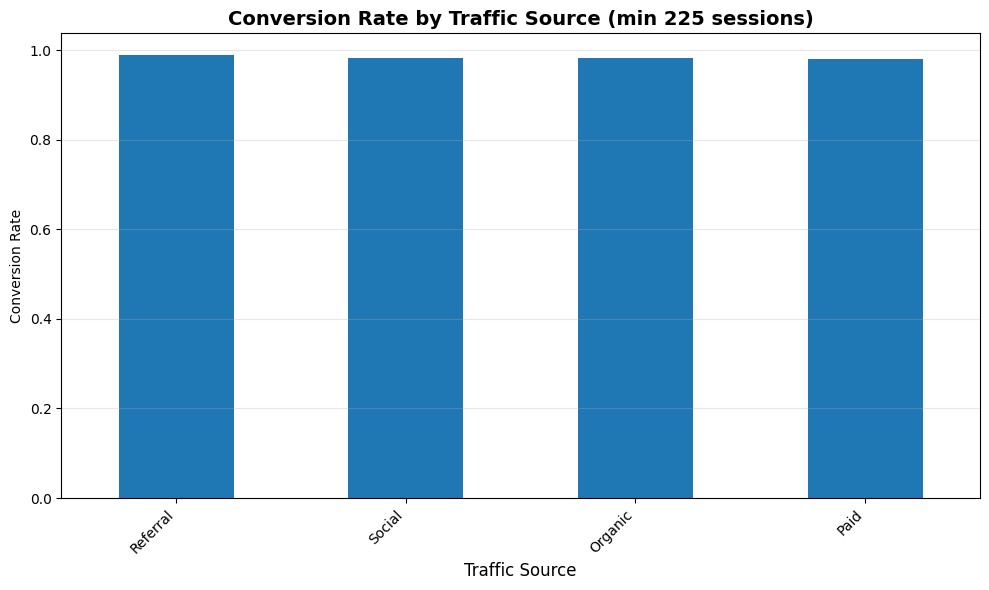

Included Sources: 4
Excluded Sources: 1


In [25]:
sessions_by_source = df_clean['Traffic Source'].value_counts()

umbral_min = 225
valid_sources = sessions_by_source[sessions_by_source >= umbral_min].index

df_filtered = df_clean[df_clean['Traffic Source'].isin(valid_sources)]

cr_by_source = df_filtered.groupby('Traffic Source')['Conversion Rate'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
cr_by_source.plot(kind='bar')
plt.title(f'Conversion Rate by Traffic Source (min {umbral_min} sessions)', fontsize=14, fontweight='bold')
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/conversion_by_source.png", dpi=120)

plt.show()

print(f"Included Sources: {len(valid_sources)}")
print(f"Excluded Sources: {len(sessions_by_source) - len(valid_sources)}")


## 4. Previous Visits (recency) analysis

In this section we look at how prior exposure to the site relates to behavior and conversion. We segment sessions into three groups based on `Previous Visits` (new users, light returners, and highly loyal users) and compare their typical session duration, pages viewed, and average conversion. The goal is to see whether more loyal users clearly behave or convert differently.


In [10]:
# Distribution of Previous Visits
df_clean["Previous Visits"].describe()
df_clean["Previous Visits"].value_counts().sort_index()

# Segment previous visits into 0, 1–3, 4–9
df_seg = df_clean.copy()

df_seg["PrevVisitsGroup"] = pd.cut(
    df_seg["Previous Visits"],
    bins=[-0.1, 0, 3, 9],
    labels=["0", "1-3", "4-9"]
)

df_rec = df_seg.groupby("PrevVisitsGroup", observed=True).agg(
    sessions=("Session Duration", "count"),
    median_duration=("Session Duration", "median"),
    median_pageviews=("Page Views", "median"),
    mean_conversion=("Conversion Rate", "mean"),
)
df_rec


,sessions,median_duration,median_pageviews,mean_conversion
PrevVisitsGroup,,,,
0,282,2.155420,5.0,0.967540
1-3,1431,1.983088,5.0,0.983895
4-9,273,1.967850,5.0,0.990861


## 5. Session Duration segments and conversion

Here we segment sessions into duration bands using quartiles of `Session Duration` (very short, short–mid, mid–long and long sessions). For each band we inspect how often sessions convert. This allows us to test the common assumption that “longer sessions convert much better” and to quantify whether the effect is strong or only mildly positive in this dataset.


In [12]:
# Duration quantiles
q25, q50, q75 = df_clean["Session Duration"].quantile([0.25, 0.5, 0.75])
q25, q50, q75

(0.8145663210238463, 2.0061072793346044, 4.209668448696278)

In [13]:
df_dur = df_clean.copy()

df_dur["DurationGroup"] = pd.cut(
    df_dur["Session Duration"],
    bins=[0, q25, q50, q75, df_dur["Session Duration"].max()],
    labels=["very_short", "short_mid", "mid_long", "long"],
    include_lowest=True
)

df_conv_by_dur = df_dur.groupby("DurationGroup", observed=True).agg(
    sessions=("Session Duration", "count"),
    median_duration=("Session Duration", "median"),
    mean_conversion=("Conversion Rate", "mean"),
    median_conversion=("Conversion Rate", "median"),
)
df_conv_by_dur


,sessions,median_duration,mean_conversion,median_conversion
DurationGroup,,,,
very_short,497,0.396759,0.961946,1.0
short_mid,496,1.329699,0.977524,1.0
mid_long,496,2.859218,0.991377,1.0
long,497,6.340482,0.999281,1.0


## 6. Extra relationships and correlations

In this final section we explore a few additional relationships between key metrics, such as session duration vs. page views or time on page vs. bounce rate. We also compute simple correlations to understand how strongly these variables move together, complementing the more targeted analyses from the previous sections.


In [14]:
# Session Duration by Page Views
df_pv = df_clean.groupby("Page Views")["Session Duration"].agg(["count", "mean", "median"])
df_pv


,count,mean,median
Page Views,,,
1,69,2.893222,2.179118
2,170,3.217268,1.993427
3,281,3.185502,2.062960
4,354,3.068284,2.094338
5,354,2.777708,1.900495
6,296,3.271741,2.163261
7,211,2.989747,2.154071
8,135,2.649997,1.754873
9,61,2.646809,1.969349


In [15]:
df_clean[["Session Duration","Time on Page","Page Views","Bounce Rate","Previous Visits","Conversion Rate"]].describe()

df_clean[["Time on Page","Page Views","Bounce Rate"]].corr(numeric_only=True)


,Time on Page,Page Views,Bounce Rate
Time on Page,1.000000,0.020927,0.038438
Page Views,0.020927,1.000000,0.031090
Bounce Rate,0.038438,0.031090,1.000000


#### Outputs/

In [26]:
df_kpi.to_csv("../outputs/traffic_source_kpis.csv", index=False)
df_rec.to_csv("../outputs/previous_visits_summary.csv")
df_conv_by_dur.to_csv("../outputs/duration_groups_conversion.csv")
